# Rice-Mele Model: Thouless Charge Pump

In [1]:
import numpy as np
from functools import reduce
from scipy import sparse
from scipy.sparse import bsr, csr_matrix
from scipy.sparse.bsr import bsr_matrix
from typing import List
import scipy.linalg as linalg
import csv
from typing import Tuple

In [2]:
D_SITE = 2

In [3]:
class ThoulessModel:
    h_0: float
    delta_0: float
    t_0: float
    period: float
    sites: int
    all_annihilation_operators: List[bsr_matrix]
    projection_to_single_operator: bsr_matrix

    def __init__(self, h_0: float, delta_0: float, t_0: float, period: float, sites: int):
        self.h_0 = h_0
        self.delta_0 = delta_0
        self.t_0 = t_0
        self.period = period
        self.sites = sites
        assert sites > 0 and sites % 2 == 0

    def delta(self, t: float) -> float:
        return self.delta_0 * np.cos(2 * np.pi * t / self.period)

    def h_st(self, t: float) -> float:
        return self.h_0 * np.sin(2 * np.pi * t / self.period)

    def single_hamiltonian(self, t: float) -> np.ndarray:
        hamiltonian = np.zeros((self.sites, self.sites))
        for i in range(0, self.sites):
            hamiltonian[i, i] = (-1) ** i * self.h_st(t)
        for i in range(0, self.sites - 1):
            hamiltonian[i, i + 1] = 1 / 2 * (self.t_0 + self.delta(t) * (-1) ** i)
            hamiltonian[i + 1, i] = np.conj(1 / 2 * (self.t_0 + self.delta(t) * (-1) ** i))
        return hamiltonian

    def single_exact_diagonalization(self, t: float) -> Tuple[np.ndarray, np.ndarray]:
        single_hamiltonian: np.ndarray = self.single_hamiltonian(t)
        energy_levels, vectors = linalg.eigh(single_hamiltonian)
        return energy_levels, vectors.T

    def bulk_levels(self, t: float) -> np.ndarray:
        k_points = np.linspace(-np.pi, np.pi, self.sites // 2 + 1)
        levels = np.sqrt(self.h_st(t) ** 2 + self.delta(t) ** 2 *
                         np.sin(k_points / 2) ** 2 + self.t_0 ** 2 * np.cos(k_points / 2) ** 2)
        return np.concatenate(
            (levels, -levels)
        )

In [4]:
h_0 = 0.5
delta_0 = 0.2
t_0 = 1
period = 10
sites = 100
model = ThoulessModel(h_0, delta_0, t_0, period, sites)

In [5]:
steps = 201
duration = 2 * period
times = np.linspace(0, duration, steps)

exact_levels_and_vectors_by_time = [model.single_exact_diagonalization(t) for t in times]
exact_levels_by_time = np.array([levels_and_vectors[0] for levels_and_vectors in exact_levels_and_vectors_by_time])
exact_vectors_by_time = [levels_and_vectors[1] for levels_and_vectors in exact_levels_and_vectors_by_time]
occupied_edge_vector_by_time = np.array([np.abs(exact_vectors[len(exact_vectors) // 2 - 1]) ** 2 for exact_vectors in exact_vectors_by_time])
unoccupied_edge_vector_by_time = np.array([np.abs(exact_vectors[len(exact_vectors) // 2]) ** 2  for exact_vectors in exact_vectors_by_time])

bulk_levels_by_time = np.array([model.bulk_levels(t) for t in times])

In [6]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.dpi']= 300

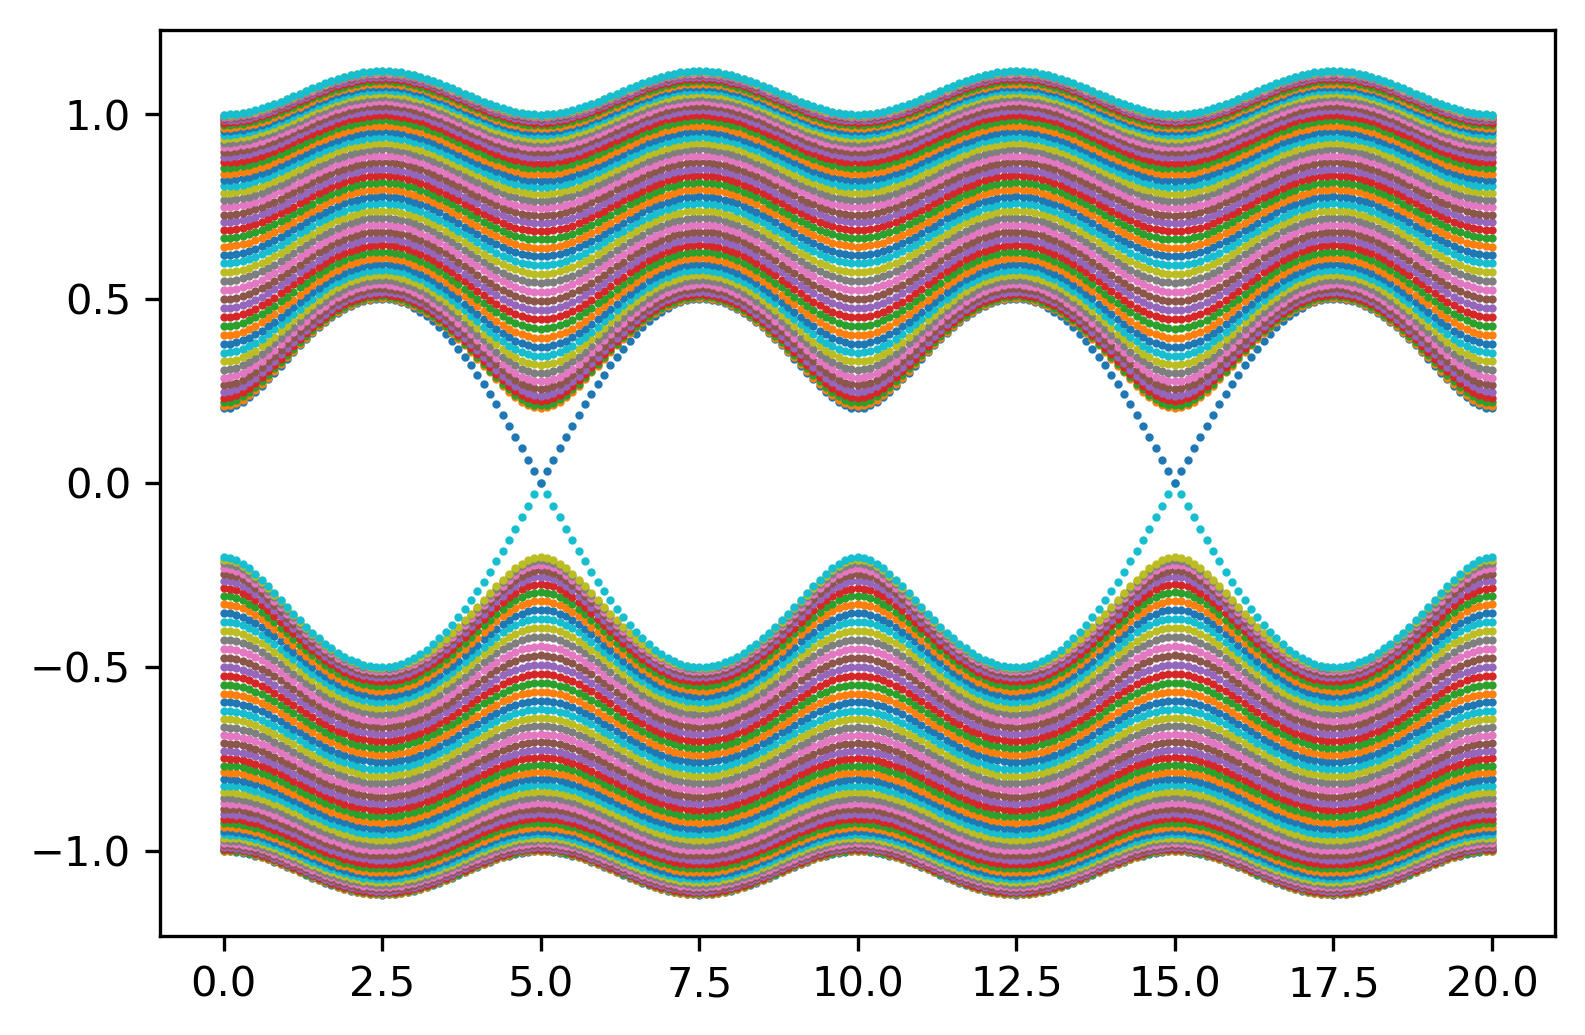

In [7]:
exact_levels_fig, exact_levels_ax = plt.subplots(1)
for i in range(exact_levels_by_time.shape[1]):
    energy_levels = exact_levels_by_time[:, i]
    exact_levels_ax.scatter(times, energy_levels, s=1)
plt.show()

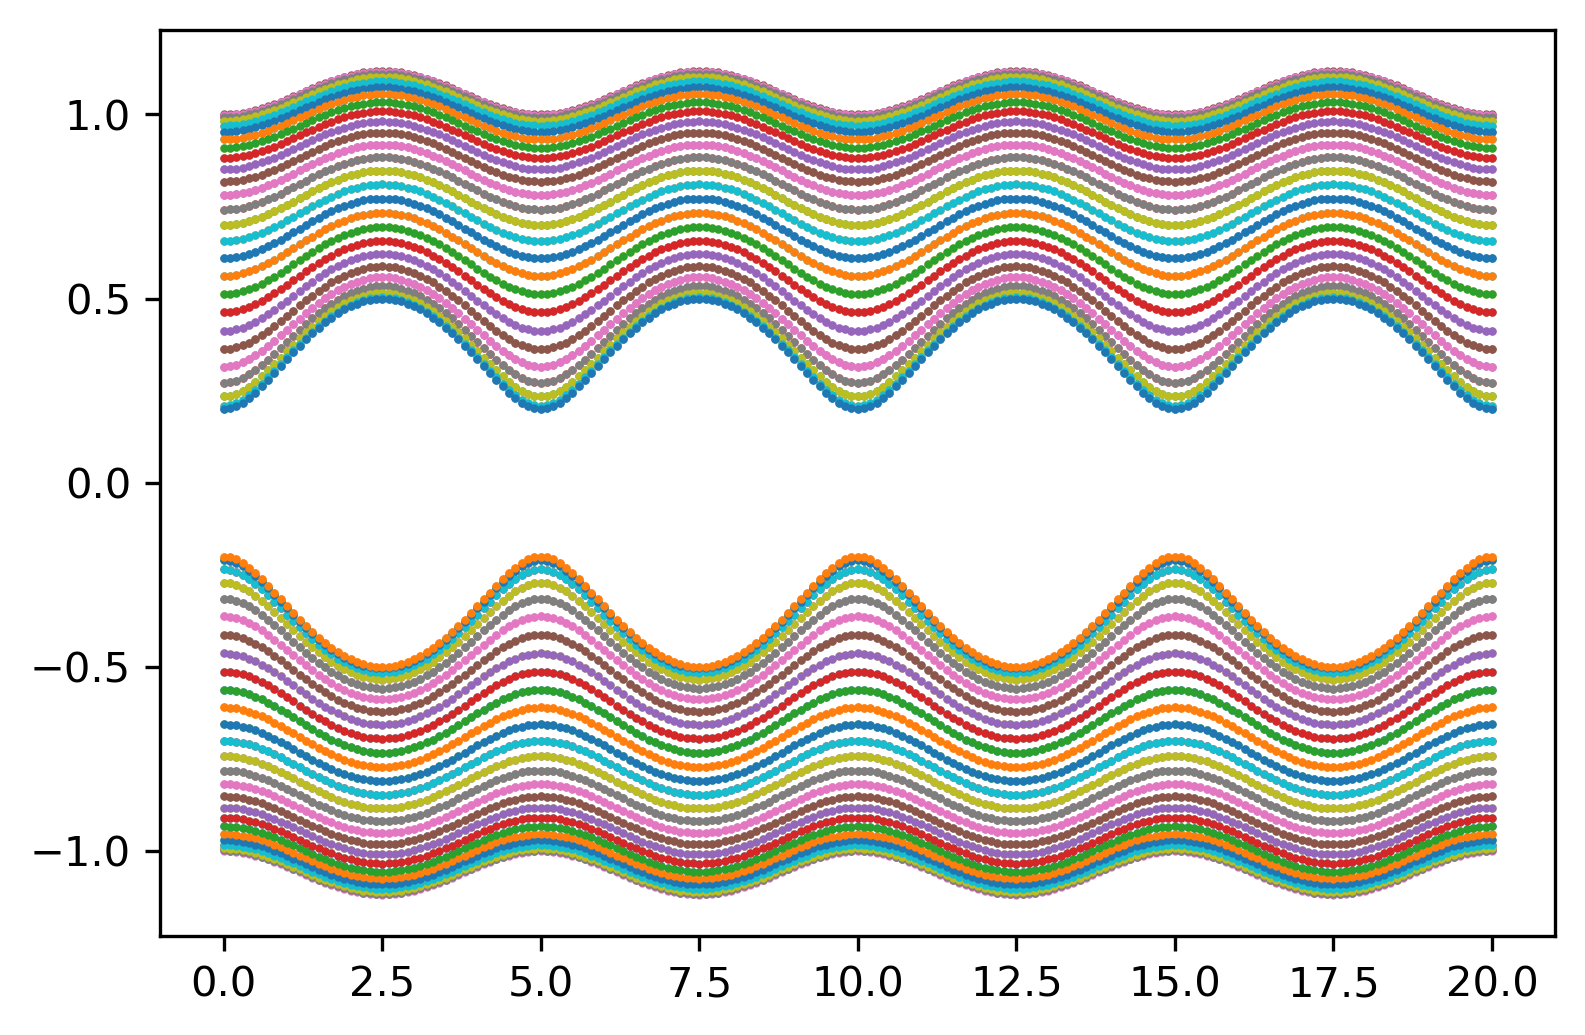

In [8]:
bulk_levels_fig, bulk_levels_ax = plt.subplots(1)
for i in range(bulk_levels_by_time.shape[1]):
    energy_levels = bulk_levels_by_time[:, i]
    bulk_levels_ax.scatter(times, energy_levels, s=1)
plt.show()

In [9]:
def plot_density(time_index):
    density_fig, density_ax = plt.subplots()
    density_ax.set_title(f'Edge states at time {time_index / steps * duration: .3}, period {duration}.')
    density_ax.set_xlabel('Relative position')
    density_ax.set_ylabel('Density summed on two sites')
    occupied_x, occupied_y = np.linspace(0, 1, sites)[::2], np.sum(occupied_edge_vector_by_time[time_index].reshape((-1, 2)), axis=1)
    unoccupied_x, unoccupied_y = np.linspace(0, 1, sites)[::2], np.sum(unoccupied_edge_vector_by_time[time_index].reshape((-1, 2)), axis=1)
    density_ax.fill_between(occupied_x, occupied_y, label='Occupied')
    density_ax.plot(occupied_x, occupied_y, '--')
    density_ax.fill_between(unoccupied_x, unoccupied_y, alpha=0.2, label='Unoccupied')
    density_ax.plot(unoccupied_x, unoccupied_y, '--', alpha=0.2)
    density_ax.legend()
    plt.show()

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [11]:
interact(plot_density, time_index=widgets.IntSlider(
    value=0,
    min=0,
    max=steps,
    step=1)
)

interactive(children=(IntSlider(value=0, description='time_index', max=201), Output()), _dom_classes=('widget-…

<function __main__.plot_density(time_index)>